# Regression Challenge

Useful SMOTE explanation + tutorial: https://blog.dominodatalab.com/imbalanced-datasets/


## Preparation / Exploration

In [171]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import preprocessing
np.set_printoptions(suppress=True)
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format
import time

In [172]:
# Read in data
df = pd.read_csv('cali_crime.csv')

In [173]:
# Preview Data
df.head()

,city of Angels,population,violent_crime,murder_nonnegligent_murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motorvehicle_theft,arson,Unnamed: 13
0,Adelanto,"31,165",198,2.000,nan,15.000,52,129,886,381,372,133,17,nan
1,Agoura Hills,"20,762",19,0.000,nan,2.000,10,7,306,109,185,12,7,nan
2,Alameda,"76,206",158,0.000,nan,10.000,85,63,"1,902",287,"1,285",330,17,nan
3,Albany,"19,104",29,0.000,nan,1.000,24,4,557,94,388,75,7,nan
4,Alhambra,"84,710",163,1.000,nan,9.000,81,72,"1,774",344,"1,196",234,7,nan


In [174]:
# Check for missing values
df.isnull().sum()

city of Angels                  0
population                      2
violent_crime                   2
murder_nonnegligent_murder      2
rape_revised                  464
rape_legacy                     2
robbery                         2
aggravated_assault              2
property_crime                  2
burglary                        2
larceny_theft                   2
motorvehicle_theft              2
arson                           2
Unnamed: 13                   464
dtype: int64

In [175]:
# Drop attributes that appear to not contain any values
df = df.drop('rape_revised',axis=1)
df = df.drop('Unnamed: 13',axis=1)

# Drop city attribute as we'll only be using numeric data for the regression omdel
df = df.drop('city of Angels',axis=1)

# Because there are so few remaining NaN values, we'll rows that have NaN
# values instead of imputing
df = df.dropna()

In [176]:
# Double check to make sure there are no missing values 
df.isnull().sum()

population                    0
violent_crime                 0
murder_nonnegligent_murder    0
rape_legacy                   0
robbery                       0
aggravated_assault            0
property_crime                0
burglary                      0
larceny_theft                 0
motorvehicle_theft            0
arson                         0
dtype: int64

In [177]:
# Preview data types for remaining attributes
df.dtypes

population                     object
violent_crime                  object
murder_nonnegligent_murder    float64
rape_legacy                   float64
robbery                        object
aggravated_assault             object
property_crime                 object
burglary                       object
larceny_theft                  object
motorvehicle_theft             object
arson                          object
dtype: object

In [178]:
# Remove commas from objects
for column in df.columns:
    if df[column].dtype == 'O':
        df[column] = df[column].str.replace(',','')

In [179]:
# Convert all attributes to numeric for model
for column in df.columns:
    df[column] = pd.to_numeric(df[column],errors='coerce')

In [180]:
# Create binary target variable for regression model 
# 0 = robbery did not occur, 1 = robbery did occur
df['robbery_target'] = np.where((df['robbery'] > 0),1,0)

In [181]:
# Drop original 'robbery' attribute
df = df.drop('robbery',axis=1)

In [182]:
# Evaluate new target variable
df['robbery_target'].value_counts()

1    427
0     35
Name: robbery_target, dtype: int64

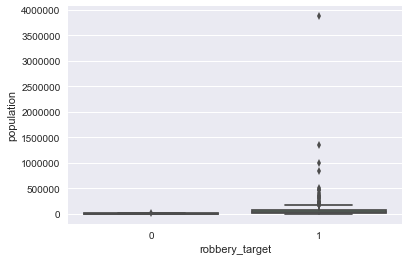

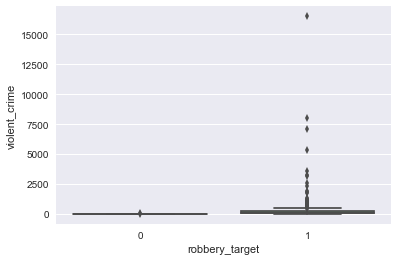

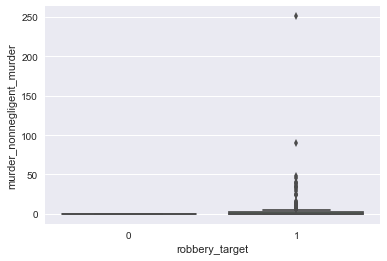

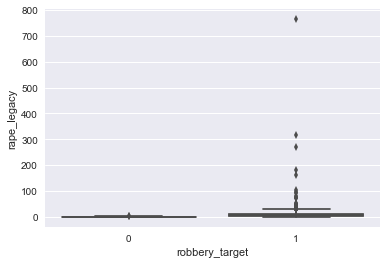

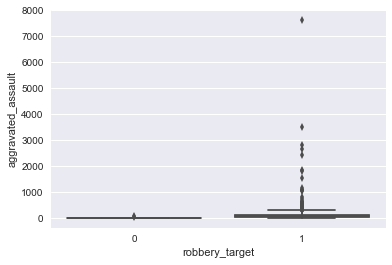

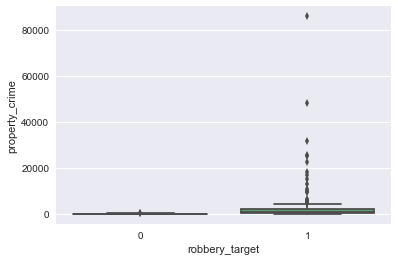

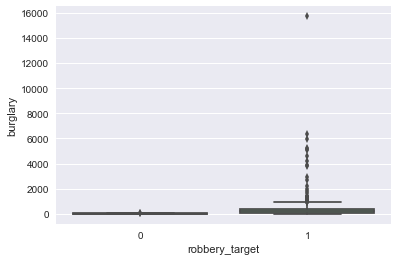

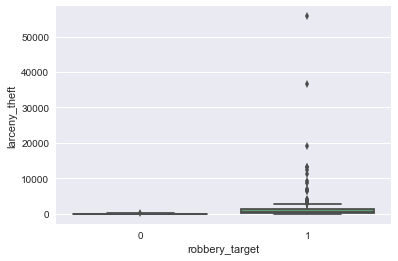

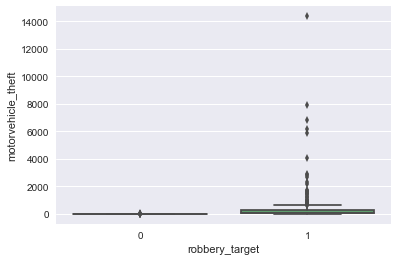

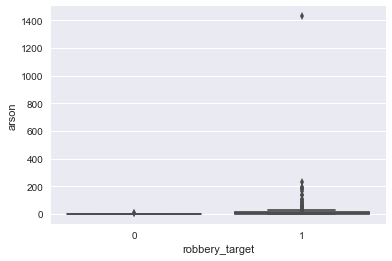

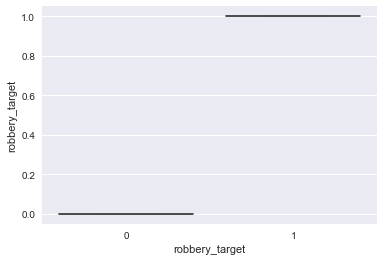

In [75]:
# Examine data; areas where no robbery occurred also have significantly lower
# crime rates in general 
for column in df.columns:
    sns.boxplot(x='robbery_target',y=column,data=df)
    plt.show()

### Addressing class imbalance

In [76]:
import imblearn.over_sampling.smote

In [183]:
from imblearn.over_sampling import SMOTE

# Assign features and target variable to 'X' and 'Y' respectively
X = df.drop('robbery_target',axis=1)
Y = df['robbery_target']

smote = SMOTE(kind = "regular")
X_sm, Y_sm = smote.fit_sample(X,Y)

In [185]:
pd.value_counts(pd.Series(Y_sm))

1    427
0    427
dtype: int64

In [186]:
cols = df.columns
cols = cols.drop('robbery_target')

sm_features = pd.DataFrame(data=X_sm,columns=cols)

sm_target = pd.DataFrame(data=Y_sm, columns = ['robbery_target'])

frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

X = sm_features
Y = sm_target.values.ravel()

In [188]:
sm_data.head(1)

,population,violent_crime,murder_nonnegligent_murder,rape_legacy,aggravated_assault,property_crime,burglary,larceny_theft,motorvehicle_theft,arson,robbery_target
0,31165.000,198.000,2.000,15.000,129.000,886.000,381.000,372.000,133.000,17.000,1


### Random Forest (RF)

/Users/wliao/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Feature ranking:
1. feature 7 (0.142313)
2. feature 1 (0.141245)
3. feature 5 (0.138948)
4. feature 0 (0.107324)
5. feature 8 (0.100476)
6. feature 6 (0.098910)
7. feature 4 (0.098309)
8. feature 3 (0.088537)
9. feature 9 (0.050846)
10. feature 2 (0.033093)


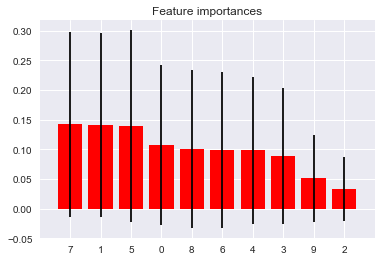

In [114]:
from sklearn.ensemble import ExtraTreesClassifier

# Instantiate model
forest = ExtraTreesClassifier(n_estimators=250)

#Fit model
forest.fit(X,Y)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [115]:
# Assign features
rf_features = X[X.columns[[indices[0:7]]]]

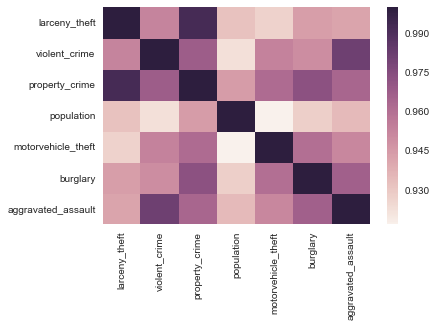

In [116]:
sns.heatmap(rf_features.corr())

### Principal Component Analysis (PCA)

In [120]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

# Assign features and target variable to 'X' and 'Y' respectively
X = sm_features
X_scaled = preprocessing.scale(X)

X_pca = pca.fit_transform(X_scaled)

Y = sm_target

[ 0.94084836  0.02317353  0.01251547  0.01001562  0.00537353  0.00435973
  0.0019072   0.00122601  0.00058057  0.        ]


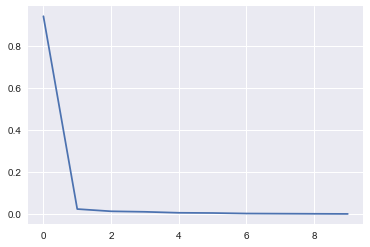

In [121]:
# Evaluate explained variance ratio -- it appears that the first component explains
# most of the data set. 
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)

In [122]:
# The first principal component explains the variance of a little over 9 of 
# our features
pca.explained_variance_

array([ 9.41951344,  0.23200693,  0.12530139,  0.10027357,  0.05379829,
        0.04364839,  0.01909433,  0.01227446,  0.00581254,  0.        ])

In [123]:
# Assign the first principal component to X_pca
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# Logistic Regression

### Using all features

In [135]:
# Fit logistic regression model
lr = LogisticRegression()
fit = lr.fit(X,Y)
print(lr.score(X,Y))

0.700234192037


In [136]:
# Evaluate performnace during cross validation
lr_score = cross_val_score(lr,X,Y,cv=10)
print(np.mean(lr_score))

0.747757475083


In [137]:
# Evaluate coefficients
print(lr.coef_)
print(lr.intercept_)

[[-0.00005948  0.01375885  0.00040655  0.00137521  0.00110429  0.00453883
  -0.01064232  0.00332636  0.0118548   0.00023975]]
[-0.00381805]


### Using top features  from random forests

In [138]:
fit = lr.fit(rf_features,Y)

In [139]:
# Evaluate performnace during cross validation
lr_rf_score = cross_val_score(lr,rf_features,Y,cv=10)
print(np.mean(lr_rf_score))

0.753571428571


In [129]:
# Evaluate coefficients
print(lr.coef_)
print(lr.intercept_)

[[ 0.00331632  0.0138161   0.00454977 -0.00005943  0.01189227 -0.01065882
   0.00110833]]
[-0.00383377]


### Using one principal components

In [140]:
# Evaluate coefficients
fit = lr.fit(X_pca,Y)

In [141]:
# Evaluate performnace during cross validation
start_time = time.time()
lr_score = cross_val_score(lr,X_pca,Y,cv=10)
print("--- %s seconds ---" % (time.time() - start_time))

print(np.mean(lr_score))

--- 0.024099111557006836 seconds ---
0.890033222591


# Ridge Regression

### Using all features

In [142]:
# Identify optimal lambda value 
ridge_cv = LogisticRegressionCV(penalty='l2')
model_cv = ridge_cv.fit(X,Y)
ridge_lambda = float(model_cv.C_)

In [143]:
# Fit Ridge regression model to data with optimal lambda value 
ridger = LogisticRegression(penalty='l2',C=ridge_lambda)
fit = ridger.fit(X,Y)
print(ridger.score(X,Y))

0.700234192037


In [144]:
# Evaluate performance during cross validation
ridge_score = cross_val_score(ridger,X,Y,cv=10)
print(np.mean(ridge_score))

0.747757475083


In [145]:
# Evaluate coefficients
print(ridger.coef_)
print(ridger.intercept_)

[[-0.00005948  0.01375901  0.00040656  0.00137523  0.0011043   0.00453885
  -0.01064246  0.00332638  0.01185494  0.00023975]]
[-0.0038181]


### Using top features  from random forests

In [146]:
# Identify optimal lambda value 
ridge_cv = LogisticRegressionCV(penalty='l2')
model_cv = ridge_cv.fit(rf_features,Y)
ridge_lambda = float(model_cv.C_)

In [147]:
# Fit Ridge regression model to data with optimal lambda value 
ridger = LogisticRegression(penalty='l2',C=ridge_lambda)
fit = ridger.fit(rf_features,Y)
print(ridger.score(rf_features,Y))

0.700234192037


In [148]:
# Evaluate performance during cross validation
start_time = time.time()
ridge_score = cross_val_score(ridger,rf_features,Y,cv=10)
print("--- %s seconds ---" % (time.time() - start_time))

print(np.mean(ridge_score))

--- 0.04677581787109375 seconds ---
0.750083056478


In [149]:
# Evaluate coefficients
print(ridger.coef_)
print(ridger.intercept_)

[[ 0.00331629  0.01381581  0.00454974 -0.00005943  0.01189201 -0.01065856
   0.00110831]]
[-0.00383369]


# Lasso Regression

### Using all features

In [150]:
# Identify optimal lambda for lasso regression model 
lasso_cv = LogisticRegressionCV(penalty='l1',solver='liblinear')
model_cv = lasso_cv.fit(X,Y)
lasso_lambda = float(model_cv.C_)

In [151]:
# Fit lesson regression model to data with optimal lambda
lassor = LogisticRegression(penalty='l1',C=lasso_lambda)
fit = lassor.fit(X,Y)
print(lassor.score(X,Y))

0.894613583138


In [152]:
# Evaluate performance during cross validation
lassor_score = cross_val_score(lassor,X,Y,cv=10)
print(np.mean(lassor_score))

0.904069767442


In [153]:
# Evaluate coefficients 
print(lassor.coef_)
print(lassor.intercept_)

[[ 0.00001274  0.00528961  0.34750341  0.10044977  0.00700682  0.00161949
   0.00268597  0.00166576 -0.00029172  0.06105123]]
[-1.97941459]


### Using top features  from random forests

In [154]:
# Identify optimal lambda for lasso regression model 
lasso_cv = LogisticRegressionCV(penalty='l1',solver='liblinear')
model_cv = lasso_cv.fit(rf_features,Y)
lasso_lambda = float(model_cv.C_)

In [155]:
# Fit lesson regression model to data with optimal lambda
lassor = LogisticRegression(penalty='l1',C=lasso_lambda)
fit = lassor.fit(rf_features,Y)
print(lassor.score(rf_features,Y))

0.900468384075


In [156]:
# Evaluate coefficients 
print(lassor.coef_)
print(lassor.intercept_)

[[ 0.00322132  0.00671463  0.00101552  0.00000466  0.0114936   0.00188164
   0.01585737]]
[-1.76184523]


## Conclusion



PCA with Logistic Regression or Lasso regression both seem to be appropriate methodologies. 

Both are comparable in performance and address the high multicollinearity within the data set. 

Picking an ideal model of the two would depend on the business case - if your model doesn't have to be interpretable, then PCA would be optimal as its performance is similar and it's computationally less expensive. 

If your interpretability is a requirement, then ridge regression with a subset of decidedly 'important features' (via Random Forests in our case) is more appropriate. 